# Envinroment setups

In [7]:

!pip install transformers accelerate bitsandbytes
!pip install --upgrade transformers accelerate bitsandbytes
!pip install datasets
!pip install sentence_transformers
!pip install faiss-cpu
!pip install torch --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118


In [8]:

# ========== Basic Python libraries ==========
import os
import json
import time
import random
import pickle
from datetime import timedelta
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt

# ========== Data and computation libraries ==========
import pandas as pd
import numpy as np
from tqdm import tqdm
from datasets import load_dataset

# ========== Deep learning and embedding models ==========
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoModelForSeq2SeqLM,
    BitsAndBytesConfig
)
from sentence_transformers import SentenceTransformer, util

# ========== FAISS for similarity search ==========
import faiss
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

# ========== Check CUDA availability ==========
print("CUDA available:", torch.cuda.is_available())


CUDA available: True


# Download dataset and simple cleaning


## Downloading the data

In [9]:
# Download the data from hugging face directly
user_reviews_0 = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_All_Beauty", split="full", trust_remote_code=True)
item_metadata = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_All_Beauty", split="full", trust_remote_code=True)
print("Sample user review:", user_reviews_0[0])
print("Sample item metadata:", item_metadata[0])


Sample user review: {'rating': 5.0, 'title': 'Such a lovely scent but not overpowering.', 'text': "This spray is really nice. It smells really good, goes on really fine, and does the trick. I will say it feels like you need a lot of it though to get the texture I want. I have a lot of hair, medium thickness. I am comparing to other brands with yucky chemicals so I'm gonna stick with this. Try it!", 'images': [], 'asin': 'B00YQ6X8EO', 'parent_asin': 'B00YQ6X8EO', 'user_id': 'AGKHLEW2SOWHNMFQIJGBECAF7INQ', 'timestamp': 1588687728923, 'helpful_vote': 0, 'verified_purchase': True}
Sample item metadata: {'main_category': 'All Beauty', 'title': 'Howard LC0008 Leather Conditioner, 8-Ounce (4-Pack)', 'average_rating': 4.8, 'rating_number': 10, 'features': [], 'description': [], 'price': 'None', 'images': {'hi_res': [None, 'https://m.media-amazon.com/images/I/71i77AuI9xL._SL1500_.jpg'], 'large': ['https://m.media-amazon.com/images/I/41qfjSfqNyL.jpg', 'https://m.media-amazon.com/images/I/41w2yzn

**Explaination**

I have tried to run a pipeline of downloading dataset using GCS and saved it to local machine, then got the data on GCS from colab, which worked out. However, to make the process smoother, it doesn't seem necessary to use GCS for this purpose in this recommendation system considering time costs.

## Data cleaning

In [10]:
# check item_metadata schema for data cleaning.
print(item_metadata.features)

{'main_category': Value(dtype='string', id=None), 'title': Value(dtype='string', id=None), 'average_rating': Value(dtype='float64', id=None), 'rating_number': Value(dtype='int64', id=None), 'features': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'description': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'price': Value(dtype='string', id=None), 'images': Sequence(feature={'hi_res': Value(dtype='string', id=None), 'large': Value(dtype='string', id=None), 'thumb': Value(dtype='string', id=None), 'variant': Value(dtype='string', id=None)}, length=-1, id=None), 'videos': Sequence(feature={'title': Value(dtype='string', id=None), 'url': Value(dtype='string', id=None), 'user_id': Value(dtype='string', id=None)}, length=-1, id=None), 'store': Value(dtype='string', id=None), 'categories': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'details': Value(dtype='string', id=None), 'parent_asin': Value(dtype='string', id=None

In [11]:
# check missing values in item_metadata as for later decision on recommendation strategies.
fields_to_check = ["title", "average_rating", "price", "rating_number", "categories"]
df_check = item_metadata.select_columns(fields_to_check).to_pandas()

for col in ["price", "average_rating", "rating_number"]:
    df_check[col] = pd.to_numeric(df_check[col], errors='coerce')

missing_report = df_check.isna().sum().to_frame(name='Missing Count')
missing_report['Total'] = len(df_check)
missing_report['Missing Rate (%)'] = (missing_report['Missing Count'] / missing_report['Total']) * 100

print(missing_report)

                Missing Count   Total  Missing Rate (%)
title                       0  112590          0.000000
average_rating              0  112590          0.000000
price                   94886  112590         84.275691
rating_number               0  112590          0.000000
categories                  0  112590          0.000000


**Explanation**

 - 84% of data in `price` field is missing. In later recommendation for this system, this feature won't be used to suit users' prefereces for prices.

- There are no missing values in title and average_rating, which can be used for generating recommended products names and used as a criteria for recommending items.

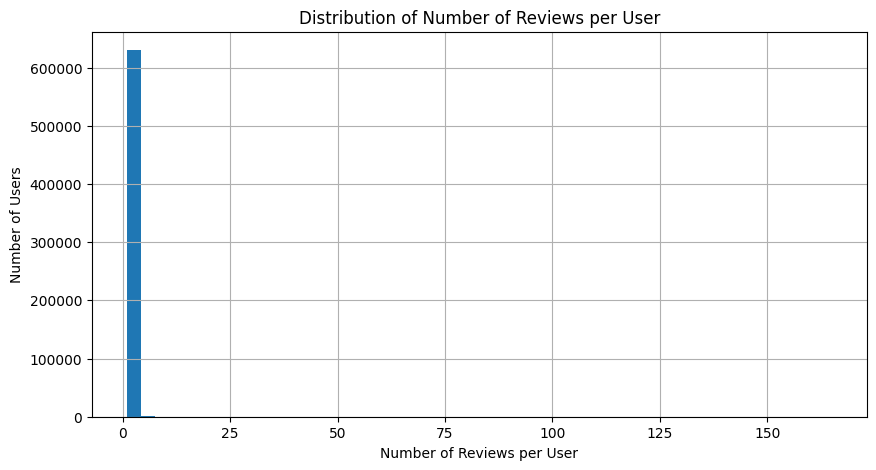

In [13]:
df_reviews = pd.DataFrame(user_reviews_0)
user_review_counts = df_reviews.groupby('user_id').size()
plt.figure(figsize=(10, 5))
user_review_counts.hist(bins=50)
plt.xlabel('Number of Reviews per User')
plt.ylabel('Number of Users')
plt.title('Distribution of Number of Reviews per User')
plt.show()

In [14]:
print(user_review_counts.describe())

count    631986.000000
mean          1.110037
std           0.753202
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         165.000000
dtype: float64


**Explanation**

 Most users left only 1 review, so in preparing corpus for constrcuting user profiles, no limit is set for the number of reviews written by each user.

In [15]:
review_lengths = df_reviews['text'].dropna().apply(len)
print(review_lengths.describe())

count    701528.000000
mean        173.031641
std         246.924645
min           0.000000
25%          44.000000
50%         102.000000
75%         209.000000
max       14989.000000
Name: text, dtype: float64


**Explanation**

In preparing the user reviews corpus, reviews no more than 25 words will be filetered as invalid or uninformative texts. This is based on the 25% percentile of the length for user reviews.

In [16]:
'''filter rules:
1. Drop reviews that are null or too short (less than 20 characters).
2. Group reviews by user_id, aggregating them into lists of comments.
3. For each user, retains only the first 10 valid reviews to control input length.
4. Keep only the user_id and the processed review text.
5. Finally, write the result into a JSONL file, where each line corresponds to one user's review data.
The JSON file named 'user_reviews_batch.jsonl' serves as input for user profiling and personalized recommendation generation.
'''

df_reviews = pd.DataFrame(user_reviews_0)
df_valid = df_reviews[df_reviews['text'].notnull() & (df_reviews['text'].str.len() > 25)] # each review must be over 25 words.
user_reviews = df_valid.groupby('user_id')['text'].apply(list).reset_index()
user_reviews.loc[:, 'reviews_text'] = user_reviews['text'].apply(lambda x: x[:10]) # for each user concat 10 valid reivews for most
user_reviews = user_reviews[['user_id', 'reviews_text']]
user_reviews.to_json("user_reviews_batch.jsonl", orient="records", lines=True)


**comment:**

in reality, such system could update every day in a big query table while there will be daily added-on data in massive DAU for e-commerce.

# Product embedding (1 LLM) + FAISS

1. We will use BAAI/bge-small-en-v1.5, an encoder-only LLM as embed model.
2. Product embeddings are created.
3. Based on the mapped product information, the top 200 most frequent n-grams are extracted and later used as a domain-specific vocabulary to evaluate user profile specificity.

In [17]:
"""
Construct a semantic product index and store associated product metadata for recommendation:

1. `build_text` function is to concatenate product title, description, and features into a single searchable string.
2. Generate text representations for all products and uses a SentenceTransformer to embed them into dense vectors.
3. These vectors are indexed using FAISS (FlatL2) for efficient similarity search.
4. The FAISS index is saved to disk along with:
   - a list of ASINs (`bge_asin_mapping.pkl`) for ID mapping,
   - and a dictionary mapping each ASIN to its product metadata (`asin_product_info.pkl`), including title, description, and average rating.

This index and metadata store will be used for real-time product retrieval and personalized recommendation based on vector similarity.
"""

embed_model = SentenceTransformer('BAAI/bge-small-en-v1.5')

def build_text(example):
    desc = example.get('description') or ""
    features = " ".join(example.get('features', [])) if example.get('features') else ""
    return f"{example['title']} {desc} {features}"

item_texts = [build_text(item) for item in item_metadata]
asin_list = [item['parent_asin'] for item in item_metadata]
item_vectors = embed_model.encode(item_texts, batch_size=64, show_progress_bar=True)

dimension = item_vectors.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(np.array(item_vectors))
faiss.write_index(index, "bge_all_beauty_faiss.index")
with open("bge_asin_mapping.pkl", "wb") as f:
    pickle.dump(asin_list, f)
asin_to_product_info = {}
for item in item_metadata:
    asin = item.get('parent_asin')
    avg_rating = float(item.get('average_rating', 0) or 0)

    title_raw = item.get('title', '')
    title_clean = title_raw.encode('ascii', 'ignore').decode('ascii').strip()
    if not title_clean:
        title_clean = "⚠️ Unformatted title"

    asin_to_product_info[asin] = {
        "title": title_clean,
        "description": item.get('description', []),
        "details": item.get('details', ""),
        "store": item.get('store', 'Unknown Store'),
        "average_rating": avg_rating
    }
with open("asin_product_info.pkl", "wb") as f:
    pickle.dump(asin_to_product_info, f)
print("✅ FAISS index + ASIN mapping saved!")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1760 [00:00<?, ?it/s]

✅ FAISS index + ASIN mapping saved!


In [18]:
def extract_top_ngrams(asin_to_product_info, top_k=100, ngram_range=(1, 3)):
    texts = []
    for info in asin_to_product_info.values():
        title = info.get('title', '')
        desc = info.get('description', '')
        if isinstance(desc, list):
            desc = " ".join(desc)
        text = f"{title} {desc}"
        texts.append(text.lower())

    # Clean text (remove punctuation, numbers)
    texts = [re.sub(r'[^a-z ]', ' ', t) for t in texts]

    # Extract ngrams
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vectorizer.fit_transform(texts)
    sums = X.sum(axis=0)
    ngrams_freq = [(ngram, sums[0, idx]) for ngram, idx in vectorizer.vocabulary_.items()]
    ngrams_freq.sort(key=lambda x: x[1], reverse=True)

    top_ngrams = [ngram for ngram, freq in ngrams_freq[:top_k]]
    return top_ngrams


''' Extract the top200 ngrams.'''
top_ngrams = extract_top_ngrams(asin_to_product_info, top_k=200, ngram_range=(1, 3))

**Comment:**

in reality, such system could update every day or in other time laps for e-commerce business.

# loading 2 LLMs (only once)

In [19]:
# model path config
class Config:
    # file dependencies.
    USER_REVIEW_FILE = "user_reviews_batch.jsonl"
    ASIN_MAPPING_FILE = "bge_asin_mapping.pkl"
    PRODUCT_INFO_FILE = "asin_product_info.pkl"
    FAISS_INDEX_FILE = "bge_all_beauty_faiss.index"

    # two LLMs
    MODEL_ID_PROFILE = "NousResearch/Nous-Hermes-2-Mistral-7B-DPO"
    MODEL_ID_SLOGAN = "google/flan-t5-large"

    # model params
    MAX_NEW_TOKENS = 250
    TEMPERATURE = 0.7
    TOP_P = 0.9
    REPETITION_PENALTY = 1.2
    MAX_REVIEW_LENGTH = 1000
    SAMPLE_SIZE = 5 # This is a current set. Change it to other numbers.

# load transformer model
embed_model = SentenceTransformer('BAAI/bge-small-en-v1.5')

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

# for generating user profile based on user_review text
profile_tokenizer = AutoTokenizer.from_pretrained(Config.MODEL_ID_PROFILE)
profile_model = AutoModelForCausalLM.from_pretrained(
    Config.MODEL_ID_PROFILE,
    device_map="auto",
    quantization_config=quant_config,
)

# for generating recommendation slogans.
slogan_tokenizer = AutoTokenizer.from_pretrained(Config.MODEL_ID_SLOGAN)
slogan_model = AutoModelForSeq2SeqLM.from_pretrained(Config.MODEL_ID_SLOGAN)

# load vector index and product info files.
with open(Config.ASIN_MAPPING_FILE, "rb") as f:
    asin_list = pickle.load(f)
with open(Config.PRODUCT_INFO_FILE, "rb") as f:
    asin_to_product_info = pickle.load(f)
index = faiss.read_index(Config.FAISS_INDEX_FILE)
all_asins = list(asin_to_product_info.keys())


tokenizer_config.json:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

# Main pipeline for generating recommended products

## Step 1: Utility & Similarity Functions


In [20]:

# Flatten nested feature structures into a flat list of strings
def flatten_features(feature_list):
    result = []
    for item in feature_list:
        if isinstance(item, dict):
            result.extend([str(v) for v in item.values()])
        else:
            result.append(str(item))
    return result

# Compute cosine similarity between two texts using sentence embeddings
''' This will be the second filter for product recommendation list after FAISS L2 distance selecting the top200. '''
def compute_similarity(text1, text2):
    vec1 = embed_model.encode([text1])[0]
    vec2 = embed_model.encode([text2])[0]
    return util.cos_sim(vec1, vec2).item()


## Step 2: Category Detection & Fallback Slogans for recommendation reasons

In [21]:

def fallback_line(category, user_profile):
    # extract preferred_products and liked_features
    preferred = []
    liked = []
    if isinstance(user_profile, dict):
        preferred = user_profile.get('preferred_products', [])
        liked = user_profile.get('liked_features', [])

    if isinstance(preferred, str):
        preferred = [preferred]
    if isinstance(liked, str):
        liked = [liked]

    #
    user_hint_list = preferred + liked
    user_hint = ", ".join([str(x) for x in user_hint_list]) or ""

    #
    fallback_map = {
        "nails": f"Nails that pop — just like your {user_hint}!",
        "hair": f"Hair that loves you back, {user_hint}.",
        "skincare": f"Glow meets {user_hint}, effortlessly.",
        "lashes": f"Lashes that steal hearts, not just looks.",
        "tools": f"Beauty tools that hustle like you.",
        "eyecare": f"Refresh your gaze — {user_hint} meets comfort.",
        "default": f"You’ll adore this {user_hint} treat!"
    }
    return fallback_map.get(category.lower(), fallback_map["default"])


# Heuristically categorize a product based on its title + description embeddings
def detect_category_embedding(title, description):
    category_keywords = {
        "nails": "nail polish manicure pedicure acrylic nail art",
        "hair": "hair wig shampoo conditioner hairpiece extensions",
        "skincare": "serum moisturizer cleanser acne toner cream skincare",
        "lashes": "eyelash lash mascara falsies eyeliner glue",
        "eyecare": "eye drop dry eyes contact lens redness allergy moisturizing",
        "tools": "beauty tool brush trimmer straightener curler razor clipper"
    }
    combined = (title + " " + description).lower()
    best_category, best_score = "default", 0.0
    for cat, keywords in category_keywords.items():
        score = compute_similarity(combined, keywords)
        if score > best_score:
            best_category, best_score = cat, score
    return best_category if best_score > 0.28 else "default"


## Step 3: Prompt Templates & Slogan Generation

In [22]:
# Generate the prompt for slogan generation
def build_ad_prompt(product_info, user_profile):
    title = product_info.get('title', 'Unknown Product')
    description = " ".join(product_info.get('description', [])) if isinstance(product_info.get('description'), list) else product_info.get('description', '')
    details = product_info.get('details', '')
    avg_rating = product_info.get('average_rating', 0)
    preferred_products = ", ".join(str(p) for p in user_profile.get('preferred_products', []))
    liked_features = ", ".join(str(p) for p in user_profile.get('liked_features', []))
    dislikes = ", ".join(str(p) for p in user_profile.get('dislikes', []))
    potential_interests = ", ".join(str(p) for p in user_profile.get('potential_interests', []))

    return f"""
You are an expert e-commerce copywriter creating unique, playful ad slogans.

Product:
- Title: {title}
- Description: {description}
- Details: {details}
- Average rating: {avg_rating}

User:
- Preferred products: {preferred_products}
- Likes: {liked_features}
- Dislikes: {dislikes}
- Interests: {potential_interests}

Your task:
- Write ONE catchy slogan (≤12 words) that excites this user.
- Match the product type (nails, hair, skincare, lashes, tools, etc.).
- Highlight the user’s likes, avoid their dislikes.
- Use playful, emotional, or surprising language.
- Do NOT copy product name, specs, or brand.
- If irrelevant, return only: SKIP.

Output:
"""

# Generate ad slogan, ensuring uniqueness and avoiding title duplication
def generate_ad_line_strict(prompt, title=None, used_vectors=None):
    inputs = slogan_tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
    outputs = slogan_model.generate(
        **inputs,
        max_new_tokens=30,
        temperature=0.7,
        top_p=0.9,
        repetition_penalty=1.2,
        do_sample=True,
        pad_token_id=slogan_tokenizer.eos_token_id
    )
    ad_line = slogan_tokenizer.decode(outputs[0], skip_special_tokens=True).strip()

    if title and ad_line.lower() in title.lower():
        return None
    if len(ad_line) < 5 or "skip" in ad_line.lower():
        return None

    if used_vectors is not None:
        ad_vec = embed_model.encode(ad_line)
        if any(util.cos_sim(ad_vec, v).item() > 0.8 for v in used_vectors):
            return None
        used_vectors.append(ad_vec)

    return ad_line


## Step 4: User Profile Inference + Product Recommendation

In [23]:
# Convert raw reviews into structured preferences via LLM
def generate_user_profile(user_reviews):
    prompt = f"""
You are a professional shopping assistant.

Analyze the following user reviews and summarize their preferences.

Reviews:
\"\"\"{user_reviews[:Config.MAX_REVIEW_LENGTH]}\"\"\"

Return JSON with:
- "preferred_products"
- "liked_features"
- "dislikes"
- "potential_interests"
"""
    inputs = profile_tokenizer(prompt, return_tensors="pt", truncation=True, max_length=1024).to(profile_model.device)
    outputs = profile_model.generate(
        **inputs,
        max_new_tokens=Config.MAX_NEW_TOKENS,
        temperature=Config.TEMPERATURE,
        top_p=Config.TOP_P,
        repetition_penalty=Config.REPETITION_PENALTY,
        pad_token_id=profile_tokenizer.eos_token_id
    )
    raw_output = profile_tokenizer.decode(outputs[0], skip_special_tokens=True)
    json_str = raw_output[raw_output.find("{"):raw_output.rfind("}")+1]
    return json.loads(json_str)

# Recommend top-K relevant products based on user profile embedding
# K=200, simple filtering by FAISS L2 distance (Euclidean distance)
def recommend_for_user(profile, top_k=5):
    if not profile:
        # Cold start fallback: top-rated products
        sorted_by_rating = sorted(
            all_asins,
            key=lambda a: float(asin_to_product_info[a].get('average_rating', 0) or 0),
            reverse=True
        )
        return sorted_by_rating[:top_k]

    # Build user embedding
    user_vector = embed_model.encode([
        " ".join(
            flatten_features(profile.get("preferred_products", [])) +
            flatten_features(profile.get("liked_features", [])) +
            flatten_features(profile.get("potential_interests", []))
        )
    ])

    # Search top products from FAISS
    distances, indices = index.search(np.array(user_vector), 200)
    candidate_asins = [asin_list[i] for i in indices[0]]

    # Evaluate candidates
    candidates = []
    for asin in candidate_asins:
        info = asin_to_product_info[asin]
        title = info.get('title', '')
        description = info.get('description', '')
        if isinstance(description, list):
            description = " ".join(description)

        product_hint = " ".join(flatten_features(profile.get("preferred_products", [])))
        sim = compute_similarity(title + " " + description, product_hint)
        rating = float(info.get('average_rating', 0) or 0)

        if sim > 0.3 and rating >= 3.3:
            candidates.append((asin, sim, rating, info))

    candidates.sort(key=lambda x: x[1], reverse=True)
    top_candidates = candidates[:top_k * 2]
    random.shuffle(top_candidates)
    final_asins = [c[0] for c in top_candidates[:top_k]]

    if len(final_asins) < top_k:
        sorted_by_rating = sorted(
            all_asins,
            key=lambda a: float(asin_to_product_info[a].get('average_rating', 0) or 0),
            reverse=True
        )
        for asin in sorted_by_rating:
            if asin not in final_asins and float(asin_to_product_info[asin].get('average_rating', 0) or 0) >= 3.3:
                final_asins.append(asin)
            if len(final_asins) == top_k:
                break

    return final_asins


## Step 5: Output Presentation & Main Loop for recommendation

In [24]:

def display_recommendations(final_asins, user_profile, top_k=5):
    used_vectors = []
    for asin in final_asins[:top_k]:
        info = asin_to_product_info[asin]
        title = info.get("title", "").encode('ascii', 'ignore').decode('ascii').strip()
        if not title:
            title = "⚠️ Unformatted title"

        description = info.get("description", '')
        if isinstance(description, list):
            description = " ".join(description)

        category = detect_category_embedding(title, description)
        prompt = build_ad_prompt(info, user_profile)

        ad_line = generate_ad_line_strict(prompt, title=title, used_vectors=used_vectors)
        if not ad_line:
            ad_line = fallback_line(category, user_profile)

        print(f"- 🏭️ ASIN: {asin} | {title}")
        print(f"💬 Ad: {ad_line}\n")


def main():
    all_results = []

    # load user_id_list.txt
    with open("user_id_list.txt", "r") as f:
        target_user_ids = set(line.strip() for line in f if line.strip())

    # load user_reviews_batch.jsonl
    with open(Config.USER_REVIEW_FILE, "r") as f:
        user_reviews_all = [json.loads(line) for line in f]
    user_reviews_map = {u["user_id"]: u for u in user_reviews_all}


    print(f"✅ Total user IDs loaded from file: {len(target_user_ids)}")

    for user_id in target_user_ids:
        print(f"\n{'='*60}\n👤 User ID: {user_id}")

        # check if in user_reviews_batch.jsonl
        if user_id in user_reviews_map:
            user = user_reviews_map[user_id]
            reviews_text = " ".join(user["reviews_text"])
            is_cold_start = False

            try:
                profile = generate_user_profile(reviews_text)
                if not profile.get("preferred_products") or not profile.get("liked_features"):
                    print("⚠️ Cold start: Insufficient profile data.")
                    is_cold_start = True
                    profile = None
            except Exception as e:
                print(f"⚠️ Skipping: Profile generation failed - {str(e)}")
                is_cold_start = True
                profile = None
        else:
            print("⚠️ Cold start: No user reviews found.")
            is_cold_start = True
            profile = None

        # recommendations
        if is_cold_start:
            final_asins = random.sample(all_asins, 5)
            ad_texts = ["Enjoy this product!"] * 5
            print("⚠️ Using fallback recommendations for cold start.")
        else:
            print(f"🔹 User Profile:\n{json.dumps(profile, indent=2)}")
            final_asins = recommend_for_user(profile, top_k=5)
            ad_texts = []
            used_vectors = []
            for asin in final_asins:
                info = asin_to_product_info[asin]
                title = info.get("title", "Unknown Product")
                description = info.get("description", '')
                if isinstance(description, list):
                    description = " ".join(description)
                category = detect_category_embedding(title, description)
                prompt = build_ad_prompt(info, profile)
                ad_line = generate_ad_line_strict(prompt, title=title, used_vectors=used_vectors)
                if not ad_line:
                    ad_line = fallback_line(category, profile)
                ad_texts.append(ad_line)
                print(f"- 🏭️ ASIN: {asin} | {title}")
                print(f"💬 Ad: {ad_line}\n")

        all_results.append({
            "user_id": user_id,
            "profile": profile,
            "final_asins": final_asins,
            "ad_texts": ad_texts,
            "cold_start": is_cold_start
        })

    # save recommendation results
    with open("recommendation_results.pkl", "wb") as f:
        pickle.dump(all_results, f)
    print("✅ Saved recommendation results to recommendation_results.pkl")
    print("\n✅ Pipeline completed!")



## Step 6 Evaluations for LLM-generated contents

In [ ]:
# Evaluate extracted user profiles
def calculate_specificity_scores(user_profiles, specific_terms):
    scores = []
    specific_terms_set = set([term.lower() for term in specific_terms])

    for idx, profile in enumerate(user_profiles):
        if not profile:  # skip cold start
            scores.append(None)
            continue

        hits = 0
        total = 0
        for key in ["preferred_products", "liked_features", "dislikes"]:
            items = profile.get(key, [])
            for item in items:
                item_str = str(item).lower()
                total += 1
                if any(term in item_str for term in specific_terms_set):
                    hits += 1

        score = hits / total if total > 0 else 0
        scores.append(score)
        print(f"Profile {idx + 1}: Specificity Score = {score:.2f}")

    return scores


# for recommendation evaluation
def evaluate_recommendations(final_asins_list, ad_texts_list, user_profiles, asin_to_product_info, embed_model):
    import numpy as np
    from sentence_transformers import util

    total_cos_sim = 0
    total_rating = 0
    ad_set = set()
    total_ads = 0
    cold_start_count = 0

    cold_ad_set = set()
    cold_rating_sum = 0
    cold_ad_count = 0

    noncold_ad_set = set()
    noncold_rating_sum = 0
    noncold_ad_count = 0

    for asins, ads, profile in zip(final_asins_list, ad_texts_list, user_profiles):
        if profile:
            user_vec = embed_model.encode(
                " ".join(
                    flatten_features(profile.get("preferred_products", [])) +
                    flatten_features(profile.get("liked_features", []))
                )
            )
        else:
            user_vec = None
            cold_start_count += 1

        user_cos_sims = []
        for asin, ad in zip(asins, ads):
            item_info = asin_to_product_info[asin]
            item_title = item_info.get('title', '')
            item_desc = " ".join(item_info.get('description', [])) if isinstance(item_info.get('description'), list) else item_info.get('description', '')
            item_vec = embed_model.encode(item_title + " " + item_desc)

            if user_vec is not None:
                sim = util.cos_sim(user_vec, item_vec).item()
                user_cos_sims.append(sim)

            total_rating += float(item_info.get('average_rating', 0) or 0)
            ad_set.add(ad.lower())
            total_ads += 1

            if user_vec is None:
                cold_rating_sum += float(item_info.get('average_rating', 0) or 0)
                cold_ad_set.add(ad.lower())
                cold_ad_count += 1
            else:
                noncold_rating_sum += float(item_info.get('average_rating', 0) or 0)
                noncold_ad_set.add(ad.lower())
                noncold_ad_count += 1

        if user_cos_sims:
            total_cos_sim += np.mean(user_cos_sims)

    cold_start_ratio = cold_start_count / len(user_profiles) if len(user_profiles) else 0

    avg_cos_sim = total_cos_sim / (len(user_profiles) - cold_start_count) if (len(user_profiles) - cold_start_count) else 0
    avg_rating = total_rating / total_ads if total_ads else 0
    ad_dup_ratio = 1 - (len(ad_set) / total_ads) if total_ads else 0

    cold_ad_dup_ratio = 1 - (len(cold_ad_set) / cold_ad_count) if cold_ad_count else 0
    cold_avg_rating = cold_rating_sum / cold_ad_count if cold_ad_count else 0

    noncold_ad_dup_ratio = 1 - (len(noncold_ad_set) / noncold_ad_count) if noncold_ad_count else 0
    noncold_avg_rating = noncold_rating_sum / noncold_ad_count if noncold_ad_count else 0

    print("\n📊 Evaluation Results (Overall):")
    print(f" AvgCosSim (semantic relevance, non-cold users): {avg_cos_sim:.2%}")
    print(f" AdDupRatio (ad diversity, all users): {ad_dup_ratio:.2%}")
    print(f" AvgRating (average item rating, all users): {avg_rating:.2f}")
    print(f" Cold Start Users Count: {cold_start_count}/{len(user_profiles)}")
    print(f" Cold Start Ratio: {cold_start_ratio:.2%}")

    print("\n📊 Evaluation Results (Cold Start Users Only):")
    print(f" AdDupRatio: {cold_ad_dup_ratio:.2%}")
    print(f" AvgRating: {cold_avg_rating:.2f}")

    print("\n📊 Evaluation Results (Non-Cold Start Users Only):")
    print(f" AdDupRatio: {noncold_ad_dup_ratio:.2%}")
    print(f" AvgRating: {noncold_avg_rating:.2f}")

# Numeric study for this project

### read in 50 uids

In [ ]:
# Step 1: Read the CSV file
csv_file = "sampled_users_200_part-00000-ef016e81-87ea-4682-a672-ae7d87b3635f-c000.csv"
df = pd.read_csv(csv_file)

# Step 2: Extract uid list (assuming the column is named 'user_id')
uids = df['user_id'].dropna().unique().tolist()

# Check how many were loaded
print(f"✅ Loaded {len(uids)} user IDs from CSV.")

# Step 3: Save to user_id_list.txt
with open("user_id_list.txt", "w") as f:
    for uid in uids:
        f.write(f"{uid}\n")

print("✅ Saved user IDs to user_id_list.txt.")

✅ Loaded 50 user IDs from CSV.
✅ Saved user IDs to user_id_list.txt.


### generate the recommended products

In [ ]:
main()

✅ Total user IDs loaded from file: 50

👤 User ID: AEHMB75USBWCEXDUBZKS5XVC5MGQ
🔹 User Profile:
{
  "preferred_products": "attractive, functional",
  "liked_features": "decent price",
  "dislikes": "break easily",
  "potential_interests": "teens, children"
}
- 🏭️ ASIN: B085421W6G | .
💬 Ad: : "Bubbles and squishy flakes"

- 🏭️ ASIN: B08NBDP8NR | [Heynature] Erseongcho Ampoule 40ml
💬 Ad: Hey nature erseongcho ampoule 40ml.

- 🏭️ ASIN: B00PB7HX3E | &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
💬 Ad: Refresh your gaze — attractive, functional, decent price meets comfort.

- 🏭️ ASIN: B07167YF4Z | BOURJOIS COUP DE FOUDRE EAU DE PARFUM CLIN DOEIL BOURJOIS
💬 Ad: Beauty tools that hustle like you.

- 🏭️ ASIN: B00BKUOU2S | La Perla Crme pour le Corps 200g
💬 Ad: La Perla Crme pour le Corps 200g.


👤 User ID: AFBFBKYQTJXQ324BCQ5EWKLKLJEA
🔹 User Profile:
{
  "preferred_products": [
    "novelty toys"
  ],
  "liked_features": [
    "cool",
    "kids love it"
  ],
  "dislikes": [
    "flimsiness"
  ],
  "potential_i

### Evaluation

In [ ]:
# for user profiles
specificity_scores = calculate_specificity_scores(user_profiles, top_ngrams)
valid_scores = [s for s in specificity_scores if s is not None]
average_score = np.mean(valid_scores)

print(f"\n✅ Average Specificity Score (Non-Cold Start Users): {average_score:.2f}")


Profile 1: Specificity Score = 0.00
Profile 2: Specificity Score = 0.50
Profile 3: Specificity Score = 0.50
Profile 4: Specificity Score = 0.50
Profile 10: Specificity Score = 0.20
Profile 11: Specificity Score = 1.00
Profile 13: Specificity Score = 0.67
Profile 14: Specificity Score = 0.50
Profile 17: Specificity Score = 0.67
Profile 21: Specificity Score = 1.00
Profile 22: Specificity Score = 0.50
Profile 25: Specificity Score = 0.60
Profile 26: Specificity Score = 0.50
Profile 27: Specificity Score = 0.60
Profile 34: Specificity Score = 0.50
Profile 36: Specificity Score = 0.33
Profile 37: Specificity Score = 1.00
Profile 38: Specificity Score = 0.33
Profile 40: Specificity Score = 0.00
Profile 41: Specificity Score = 1.00
Profile 42: Specificity Score = 0.20
Profile 43: Specificity Score = 0.50
Profile 48: Specificity Score = 0.00

✅ Average Specificity Score (Non-Cold Start Users): 0.50


In [ ]:
# for recommended items.
# Step 1: Load the saved results from pipeline
with open("recommendation_results.pkl", "rb") as f:
    all_results = pickle.load(f)

# Step 2: Prepare input lists
final_asins_list = [res["final_asins"] for res in all_results]
ad_texts_list = [res.get("ad_texts", [""] * len(res["final_asins"])) for res in all_results]
user_profiles = [res["profile"] for res in all_results]

# Step 3: Run the evaluation function
evaluate_recommendations(
    final_asins_list=final_asins_list,
    ad_texts_list=ad_texts_list,
    user_profiles=user_profiles,
    asin_to_product_info=asin_to_product_info,
    embed_model=embed_model
)



📊 Evaluation Results (Overall):
 AvgCosSim (semantic relevance, non-cold users): 71.79%
 AdDupRatio (ad diversity, all users): 61.60%
 AvgRating (average item rating, all users): 4.11
 Cold Start Users Count: 27/50
 Cold Start Ratio: 54.00%

📊 Evaluation Results (Cold Start Users Only):
 AdDupRatio: 99.26%
 AvgRating: 3.95

📊 Evaluation Results (Non-Cold Start Users Only):
 AdDupRatio: 17.39%
 AvgRating: 4.31


# Reproducive experiment (if needed)

In [ ]:
# in case you don't have the user_reviews files, please run the following.
# user_reviews = pd.read_json("user_reviews_batch.jsonl", lines=True)

# Here you can do your own test by randomly select a number of users.
sample_size = 50
sample_uids = user_reviews['user_id'].sample(n=sample_size, random_state=42).tolist()

# save uids to user_id_list.txt
with open("user_id_list.txt", "w") as f:
    for uid in sample_uids:
        f.write(f"{uid}\n")


In [ ]:
# generate recommended products with ad slogans.
main()


✅ Processing 50 users.

👤 User ID: AE3W45H76GLIR6MSHGENXVWWPDWA
⚠️ Cold start: Insufficient profile data.
⚠️ Using fallback recommendations for cold start.

👤 User ID: AE77AOIBJZWP7U6XVJVPQSGH7DJA
🔹 User Profile:
{
  "preferred_products": [
    "pencils"
  ],
  "liked_features": [
    "good at filling out sparse areas",
    "small brush (if applicable)"
  ],
  "dislikes": [
    "doesn't provide dramatic results",
    "not long lasting"
  ],
  "potential_interests": [
    "eyebrow pencils with longer lasting effects",
    "alternatives that provide more natural-looking results"
  ]
}
- 🏭️ ASIN: B08WZ9C2K5 | Waterproof Brow Definer, Pro Pencil, Eyebrow Pencil (Medium Brown)
💬 Ad: Lashes that steal hearts, not just looks.

- 🏭️ ASIN: B07HP8DCG8 | Brow Define Pencil (Natural Blonde 01)
💬 Ad: The natural-looking pencil will give your eyebrows a long-lasting boost.

- 🏭️ ASIN: B08WYZL3ZZ | Waterproof Brow Definer, Pro Pencil, Eyebrow Pencil (chocolate)
💬 Ad: Lashes that steal hearts, not jus

In [ ]:
# Evaluation for generated contents: products and ad slogans.

# Step 1: Load the saved results from pipeline
with open("recommendation_results.pkl", "rb") as f:
    all_results = pickle.load(f)

# Step 2: Prepare input lists
final_asins_list = [res["final_asins"] for res in all_results]
ad_texts_list = [res.get("ad_texts", [""] * len(res["final_asins"])) for res in all_results]
user_profiles = [res["profile"] for res in all_results]

# Step 3: Run the evaluation function
evaluate_recommendations(
    final_asins_list=final_asins_list,
    ad_texts_list=ad_texts_list,
    user_profiles=user_profiles,
    asin_to_product_info=asin_to_product_info,
    embed_model=embed_model
)



📊 Evaluation Results (Overall):
 AvgCosSim (semantic relevance, non-cold users): 73.39%
 AdDupRatio (ad diversity, all users): 52.80%
 AvgRating (average item rating, all users): 4.17
 Cold Start Users Count: 17/50
 Cold Start Ratio: 34.00%

📊 Evaluation Results (Cold Start Users Only):
 AdDupRatio: 98.82%
 AvgRating: 3.94

📊 Evaluation Results (Non-Cold Start Users Only):
 AdDupRatio: 29.09%
 AvgRating: 4.28


In [ ]:
# Evaluation for extracted user profiles

specificity_scores = calculate_specificity_scores(user_profiles, top_ngrams)
valid_scores = [s for s in specificity_scores if s is not None]
average_score = np.mean(valid_scores)

print(f"\n✅ Average Specificity Score (Non-Cold Start Users): {average_score:.2f}")


✅ Average Specificity Score (Non-Cold Start Users): 0.55
